# Índices de salarios y precios de la vivienda en Ciudad de México

In [47]:
##Borrar datos del entorno
rm(list=ls())

In [48]:
#Paquetería
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,srvyr,janitor,showtext,httr,jsonlite)
font_add_google("Poppins", "pop")
showtext_auto()

Para obtener los datos de 2005 a 2009 de la ENOE, se utilizará un do file de Stata para descargar los datos. Posteriormente, estos datos se juntarán con los datos de 2010 a 2023 que se encuentran en un archivo .csv. 

In [49]:
urldofile<- "https://raw.githubusercontent.com/claudiodanielpc/enoe/main/descarga_enoe_3.do"

In [50]:
#Cambiar directorio de trabajo. Este depende de la ubicación de los archivos en cada computadora
setwd("C:/Users/claud/Desktop")

In [51]:
#Descarga de archivo .do
download.file(urldofile, destfile = "descarga_enoe_3.do")

In [52]:
# Path a archivo ejecutable de Stata. Cambiar por la ubicación en cada computadora
stata_path <- "C:/Program Files/Stata17/StataMP-64.exe"  

# Path al archivo do
do_file_path <- "C:/Users/claud/Desktop/descarga_enoe_3.do"

# Crear comando para ejecutar el archivo do
command <- paste0('"', stata_path, '" -e do "', do_file_path, '"')  

# Ejecutar el comando
system(command)

[1] 0

In [53]:
procesar_archivo <- function(year, quarter, dir) {
    # Diferentes nombres de archivos
    file_names <- c(
        paste0("SDEMT", quarter, substr(year, 3, 4), ".csv"), 
        paste0("sdemt", quarter, substr(year, 3, 4), ".csv")   
    )

    # Inicializar variable para almacenar la ruta del archivo válido
    valid_filepath <- NULL

    # Revisar si existe alguno de los archivos
    for (file_name in file_names) {
        file_path <- file.path(dir, file_name) # Construir el file path
        if (file.exists(file_path)) {
            valid_filepath <- file_path
            break
        }
    }

    # Procesar si se encontró un archivo válido
    if (!is.null(valid_filepath)) {
        tablas <- read.csv(valid_filepath) %>%
            janitor::clean_names() %>%
            filter(ent == 9, clase2 == 1, r_def == 0, c_res %in% 1:3, eda >= 15 & eda <= 98)

        # Determinar variables de diseño
        strata_var <- if ("est_d_tri" %in% names(tablas)) "est_d_tri" else "est_d"
        fac_var <- if ("fac_tri" %in% names(tablas)) "fac_tri" else "fac"

        # Diseño muestral
        dm <- tablas %>%
            as_survey(weights = fac_var, strata = strata_var, ids = upm)

        # Obtener resultados
        results <- dm %>%
            summarise(pob_ocupada = survey_total(), ing_prom = survey_mean(ingocup)) %>%
            select(-contains("_se")) %>%
            mutate(año = year, trimestre = quarter)

        return(results)
    } else {
        cat("Archivo no encontrado para procesar: ", file_path, "\n")
        return(NULL)
    }
}

In [54]:
# Procesar archivos
dir <- "C:/datos/enoe/"

years <- c(2005:2009)
quarters <- c(1:4)

result_list <- list()

for (year in years) {
    for (quarter in quarters) {
        result_list[[length(result_list) + 1]] <- procesar_archivo(year, quarter, dir)
    }
    }
    
# Unir resultados

result_df <- bind_rows(result_list)
result_df

pob_ocupada,ing_prom,año,trimestre
<dbl>,<dbl>,<int>,<int>
3856920,4192.974,2005,1
3900326,4143.174,2005,2
3882520,4193.137,2005,3
4018986,4432.750,2005,4
3981345,4326.829,2006,1
3983385,4429.098,2006,2
4055073,4546.736,2006,3
4032906,4490.596,2006,4
4036440,4556.021,2007,1


Se descargan los datos de 2010 a 2023

In [55]:
##
restantes<-read.csv("https://raw.githubusercontent.com/claudiodanielpc/vivienda_cdmx/main/precios/Evolucion-salario-promedio-mensual-en-Ciudad-de-Mexico.csv")%>%
janitor::clean_names()%>%
select(quarter_id,monthly_wage,workforce)%>%
#Crear año y trimestre
mutate(año=as.integer(substr(quarter_id,1,4)),
       trimestre=as.integer(substr(quarter_id,5,6)))%>%
select(-quarter_id)%>%
rename(ing_prom=monthly_wage,
         pob_ocupada=workforce)
restantes

ing_prom,pob_ocupada,año,trimestre
<dbl>,<int>,<int>,<int>
4237.439,3960254,2010,1
4347.174,3972700,2010,2
4196.546,4024348,2010,3
3815.434,3927011,2010,4
3931.049,3931449,2011,1
4000.646,3983951,2011,2
4064.355,4036026,2011,3
3802.344,4128315,2011,4
4040.757,4068333,2012,1


In [56]:
#Unir con datos de la ENOE
salarios<-result_df%>%
bind_rows(restantes)%>%
#Ordenar
arrange(año,trimestre)
salarios

pob_ocupada,ing_prom,año,trimestre
<dbl>,<dbl>,<int>,<int>
3856920,4192.974,2005,1
3900326,4143.174,2005,2
3882520,4193.137,2005,3
4018986,4432.750,2005,4
3981345,4326.829,2006,1
3983385,4429.098,2006,2
4055073,4546.736,2006,3
4032906,4490.596,2006,4
4036440,4556.021,2007,1


Se obtiene el INPC de INEGI para el periodo 2005-2023 y se le cambia la base a 2005 Q1 = 100. Posteriormente, se unen los datos de salarios con el INPC.

In [57]:
consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))
  return(df)
}

In [58]:
url_inegi<-"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/628194/es/0700/false/BIE/2.0/ef8c858c-1f87-6408-5630-fb5496f609bf/?type=json"


In [59]:
inpc<-consulta_api(url_inegi)%>%
pluck("Series")%>%
pluck("OBSERVATIONS")%>%
as.data.frame()%>%
janitor::clean_names()%>%
#Filtrar fecha
filter(time_period >= "2005/01" & time_period <= "2023/12")%>%
mutate(obs_value=as.numeric(obs_value))%>%
#Extrar mes y año de la variable time_period
separate(time_period, into = c("año", "mes"), sep = "/")%>%
#Dejar solo los datos de diciembre
arrange(año)%>%
select(año,mes,obs_value)%>%
  mutate(trimestre = case_when(
    mes %in% c("01", "02", "03") ~ 1,
    mes %in% c("04", "05", "06") ~ 2,
    mes %in% c("07", "08", "09") ~ 3,
    mes %in% c("10", "11", "12") ~ 4
  )) %>%
  group_by(año, trimestre) %>%
  summarise(obs_value = mean(obs_value, na.rm = TRUE))%>%
ungroup()%>%
#Cambiar la base a 2005 q1 = 100
mutate(inpcbase=obs_value/obs_value[1]*100)%>%
mutate(año=as.integer(año))

inpc
#Salvar datos
write.csv(inpc,"inpc.csv",row.names = FALSE)

`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


año,trimestre,obs_value,inpcbase
<int>,<dbl>,<dbl>,<dbl>
2005,1,58.52657,100.0000
2005,2,58.85882,100.5677
2005,3,59.12769,101.0271
2005,4,59.86246,102.2825
2006,1,60.69083,103.6979
2006,2,60.69843,103.7109
2006,3,61.22184,104.6052
2006,4,62.34360,106.5219
2007,1,63.17922,107.9496


In [60]:
#Unir con datos de salarios
salarios_act<-salarios%>%
left_join(inpc,by=c("año","trimestre"))%>%
mutate(ing_prom_05=ing_prom*100/inpcbase)%>%
#Crear indice de salarios
mutate(indice_salarios=ing_prom_05/ing_prom_05[1]*100)%>%
select(año,trimestre,indice_salarios)

salarios_act

año,trimestre,indice_salarios
<int>,<dbl>,<dbl>
2005,1,100.00000
2005,2,98.25452
2005,3,98.98720
2005,4,103.35929
2006,1,99.51249
2006,2,101.85180
2006,3,103.66311
2006,4,100.54096
2007,1,100.65663


Se obtienen datos de la Sociedad Hipotecaria Federal para el índice de precios de la vivienda en Ciudad de México. Al igual que el índice de salarios, se cambia la base a 2005 Q1 = 100. Posteriormente, se unen los datos de salarios con el índice de precios de la vivienda.

In [61]:
ipvivi<-openxlsx::read.xlsx("https://github.com/claudiodanielpc/vivienda_cdmx/raw/main/Indice%20SHF%20datos%20abiertos%201_trim_2024.xlsx")%>%
janitor::clean_names()%>%
rename(año=ano)%>%
filter(estado=="Ciudad de México")%>%
#Dejar municipio NA
filter(is.na(municipio))%>%
select(año,trimestre,indice)%>%
#Cambiar base del índice a 2005 q1 = 100
mutate(ipvivi05=indice/indice[1]*100)%>%
select(!indice)

ipvivi

año,trimestre,ipvivi05
<dbl>,<dbl>,<dbl>
2005,1,100.0000
2005,2,104.6436
2005,3,108.7844
2005,4,108.3407
2006,1,111.4463
2006,2,114.5815
2006,3,116.4744
2006,4,118.1899
2007,1,122.6264


In [62]:
#Unir con datos de salarios

final<-salarios_act%>%
left_join(ipvivi,by=c("año","trimestre"))
final

año,trimestre,indice_salarios,ipvivi05
<dbl>,<dbl>,<dbl>,<dbl>
2005,1,100.00000,100.0000
2005,2,98.25452,104.6436
2005,3,98.98720,108.7844
2005,4,103.35929,108.3407
2006,1,99.51249,111.4463
2006,2,101.85180,114.5815
2006,3,103.66311,116.4744
2006,4,100.54096,118.1899
2007,1,100.65663,122.6264


In [63]:
#Obtener últimos valores

ultimo_vivi<-final%>%
filter(año==2023 & trimestre==4)%>%
mutate(fecha=as.Date(paste0(año,"-",trimestre*3,"-01")))%>%
select(ipvivi05,fecha)

ultimo_salario<-final%>%
filter(año==2023 & trimestre==4)%>%
mutate(fecha=as.Date(paste0(año,"-",trimestre*3,"-01")))%>%
select(indice_salarios,fecha)


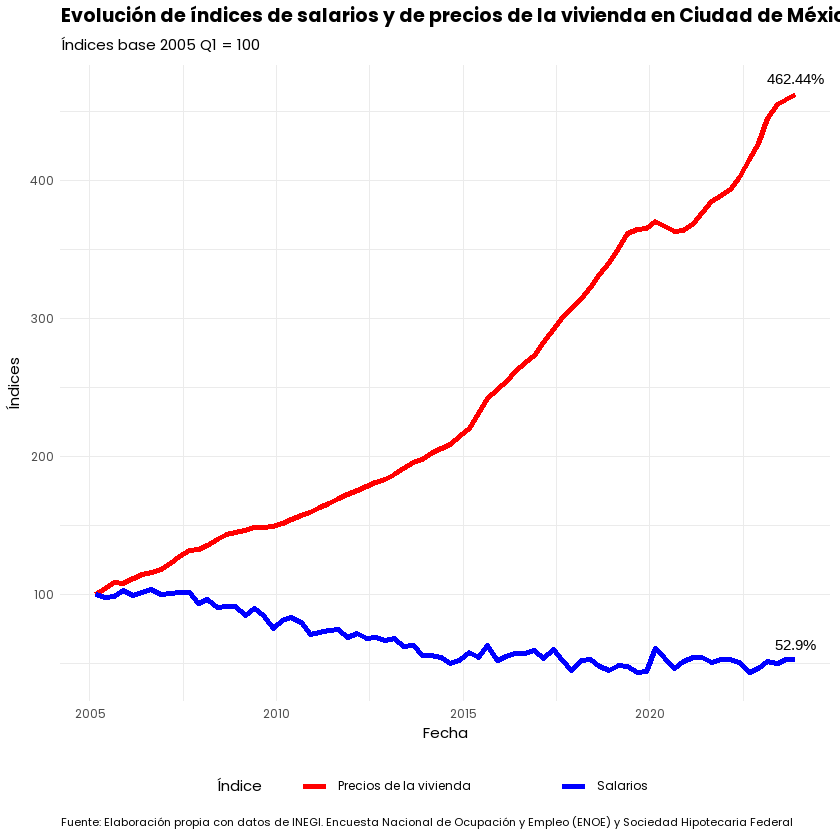

In [64]:
#Gráfica de líneas
dfexp<-final%>%
pivot_longer(-c(año,trimestre),names_to = "variable",values_to = "valor")%>%
#Crear variable de fecha de año y trimestre
mutate(fecha=as.Date(paste0(año,"-",trimestre*3,"-01")))%>%
mutate(variable=case_when(variable=="indice_salarios" ~ "Salarios",
                          variable=="ipvivi05" ~ "Precios de la vivienda"))

#guardar excel
write.csv(dfexp,"indices_salarios_vivienda.csv",row.names = FALSE)

dfexp%>%
ggplot(aes(x=fecha,y=valor,color=variable))+
geom_line(linewidth=1.5)+
#Añadir último valor de cada serie
annotate("text",x=as.Date("2023-12-01"),y=ultimo_salario$indice_salarios,label=paste0(round(ultimo_salario$indice_salarios,2),"%"),color="black",vjust=-1)+
annotate("text",x=as.Date("2023-12-01"),y=ultimo_vivi$ipvivi05,label=paste0(round(ultimo_vivi$ipvivi05,2),"%"),color="black",vjust=-1)+
labs(title="Evolución de índices de salarios y de precios de la vivienda en Ciudad de México",
     subtitle="Índices base 2005 Q1 = 100",
     x="Fecha",
     y="Índices",
     caption="Fuente: Elaboración propia con datos de INEGI. Encuesta Nacional de Ocupación y Empleo (ENOE) y Sociedad Hipotecaria Federal"

)+
theme_minimal()+
scale_color_manual("Índice",values=c("red","blue"))+
theme(text = element_text(family = "pop"),
        plot.title = element_text(hjust = 0, size=14, face="bold"),
        legend.position = "bottom",
        plot.caption = element_text(hjust = 0,size=8))

#Salvar gráfica
ggsave("grafico_indices.png",width=10,height=6,dpi=150,bg="white")